In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# DATABASE BUILDING
1. Grabbing the top 100 companies
2. Downloading those to a csv to save it
3. From that list, getting the investor relations page from their website to download the last 3-4 quarters of reports, or 2023 year
4. Connecting and reading from the folder containing all the reports in pdf format
5. Download the top 100 companies past-year historical data (2023) and store in drive
6. Convert those files into .txt format (extract the text)

-----------------------
#MODEL - Text
1. Build a BERT model
2. Train said BERT model on the press releases from 2023
3. Cluster on the embeddings using DBSCAN
4. Interpret clusters for text classification
5. Utilize predictions using a Random Forest Regressor to predict upon new press reports
6. Analyze accuracy scores and outputs

#MODEL - Stocks
1. Prepare time series model
2. LSTM(Long Short-Term Memory) Neural Network
3. Optimize for stock prediction
4. Give model date and stock ticker to predict price

-----------------------

#My github repo! (Bread & butter to this project)
* https://github.com/kkhawk20/MGSC310-Final-Project

#My Google Drive Folder (Holds more data & such)
* https://drive.google.com/drive/folders/1mHmm85q6tzB-V0usK4tMwQmzMnPX1p6P?usp=sharing

#Sources:
* https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
*

#DATABASE BUILDING

In [ ]:
#1. Grabbing the top companies off Yahoo Finance
#This was run on 11/13/23, stock data came from this day!

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os

# Function to get most active symbols from Yahoo Finance
def get_most_active_symbols(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')

    symbols = []
    for row in soup.select('tr.simpTblRow'):
        symbol = row.select_one('td:nth-of-type(1) a').text.strip()
        symbols.append(symbol)

    return symbols

most_active_symbols = get_most_active_symbols('https://finance.yahoo.com/most-active')

In [ ]:
#2. Download the top companies and save it
# DO NOT RUN THIS UNLESS YOU WANT TO DOWNLOAD THE CSV

import csv

#list of top 100 companies
your_list = most_active_symbols

# Open a new CSV file
with open('stock_tickers.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Writing each item in the list as a new row
    for item in your_list:
        writer.writerow([item])

# Download the file to your local machine (specific to Google Colab)
from google.colab import files
files.download('stock_tickers.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Grabbing the dates of the shareholder press reports for 2023 as well as the price of the stock that day

import yfinance as yf
import pandas as pd

# List of company tickers

file_path = 'https://raw.githubusercontent.com/kkhawk20/MGSC310-Final-Project/main/Market_data.csv'
stock_tickers = pd.read_csv(file_path)

tickers = stock_tickers["Symbol"]

results = pd.DataFrame(columns=["Ticker", "Date", "Stock Price"])

for ticker in tickers:
    company = yf.Ticker(ticker)
    history = company.history(period="1y")  # get one year of historical data

    for date, row in history.iterrows():
        results = results.append({
            "Ticker": ticker,
            "Date": date,
            "Stock Price": row['Close']
        }, ignore_index=True)

results.to_csv("stock_prices.csv", index=False)

In [ ]:
# 3. Grabbing all the investor relations websites and exporting to a CSV file with the subsequent Ticker
# I will now painfully go through each website and download each of the files into a shared google doc
# update ... I pulled about 20 companies, 3-4 reports each. top 10 companies listed in github->'MGSC310-Final-Project/investor_relations_website.csv'

from bs4 import BeautifulSoup
import requests
import re
import csv
import pandas as pd

# Load the CSV file containing the stock tickers
file_path = 'https://raw.githubusercontent.com/kkhawk20/MGSC310-Final-Project/main/Market_data.csv'
stock_tickers = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify the contents
stock_tickers.head()

# Function to find investor relations website for a given stock ticker
def find_investor_relations_website(ticker):
    # Constructing the Google search query
    query = f"{ticker} investor relations site"

    try:
        # Performing the search
        search_result = requests.get(f"https://www.google.com/search?q={query}")
        soup = BeautifulSoup(search_result.text, 'html.parser')

        # Finding all the links in the search result
        links = soup.find_all('a')

        for link in links:
            # Extracting the href attribute of each link
            href = link.get('href')

            # Looking for the first valid URL which is typically the company's investor relations page
            if "url?q=" in href and not "webcache.googleusercontent.com" in href:
                url = re.findall("url\?q=(.*?)&", href)
                if url:
                    return url[0]
    except Exception as e:
        return f"Error: {e}"

# Testing the function with a few tickers from the list
all_tickers = stock_tickers['Symbol']
investor_relations_websites = {ticker: find_investor_relations_website(ticker) for ticker in all_tickers}

# Open a new CSV file to download
with open('investor_relations_website.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Writing the header
    writer.writerow(['Ticker', 'Investor Relations Website'])
    # Writing each ticker and its corresponding URL as a new row
    for ticker, url in investor_relations_websites.items():
        writer.writerow([ticker, url])

# Download the file to your local
from google.colab import files
files.download('investor_relations_website.csv')

In [ ]:
#4. Connecting and reading from the folder containing all the reports in pdf format

import pdfplumber
import os

# Path to your folder in Google Drive
folder_path = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Shareholder Reports'

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.pdf'):
        file_path = os.path.join(folder_path, filename)
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                # print(f"Contents of {filename}:")
                # print(text)


In [ ]:
#5. Downloading the past-year historical data for each of the 100 companies, given the list of tickers
#DO NOT RUN THIS AGAIN DEAR GOD DO NOT RUN THIS EVER AGAIN
#This data was pulled on 11/29/23
'''Safeguards comments to not run it again

import os
import yfinance as yf
import pandas as pd

# Define the list of stock tickers
stock_tickers_data = pd.read_csv('https://raw.githubusercontent.com/kkhawk20/MGSC310-Final-Project/main/Market_data.csv')
stock_tickers = stock_tickers_data['Symbol'].tolist()

# Path to the folder in Google Drive
folder_path = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Stock Data'

# Check if the folder exists, if not create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Loop through each ticker, fetch data, and save as CSV
for ticker in stock_tickers:
    stock_data = yf.download(ticker, period='1y')  # Download past year data
    stock_data['Ticker'] = ticker  # Add a new column with the ticker
    file_path = os.path.join(folder_path, f'{ticker}.csv')
    stock_data.to_csv(file_path)

'''



In [ ]:
#7. Extract text from pdf files into another folder.
#Converting the pdf files into .txt files for BERT model
#These are the shareholder reports

#DO NOT RUN AGAIN
#STORED IN GOOGLE DRIVE FOLDER -> Shareholder Reports TXT
'''
import os
import pdfplumber

# Directory containing the PDF files
pdf_dir = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Shareholder Reports'

# Directory to store the text files
text_dir = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Shareholder Reports TXT'

# Create the text directory if it doesn't exist
if not os.path.exists(text_dir):
    os.makedirs(text_dir)

# Iterate over each file in the PDF directory
for pdf_file in os.listdir(pdf_dir):
    if pdf_file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_dir, pdf_file)
        text_path = os.path.join(text_dir, pdf_file.replace('.pdf', '.txt'))

        # Extract text and save to a .txt file
        with pdfplumber.open(pdf_path) as pdf, open(text_path, 'w') as text_file:
            for page in pdf.pages:
                text = page.extract_text()
                if text:
                    text_file.write(text)
                    text_file.write('\n')  # Add a newline between pages



#MODEL - TEXT



### ATTEMPT 1 - THIS DID NOT WORK


- This did not work. Please use as a way to follow my thought process in this project

- Utilizing BERT and embeddings to cluster, including PCA and KMeans

In [ ]:
#This is attempting to creat a list of texts from all the txt files
import os

folder_path = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Shareholder Reports TXT'
texts = []

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            texts.append(text)
            # Add a corresponding label for each text


In [ ]:
#Using Bert transformers and tokenizers to great a model and implement clustering
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
with torch.no_grad():
    outputs = model(**inputs)
embeddings = outputs.last_hidden_state.mean(dim=1).numpy()  # Use mean pooling for sentence embeddings

# Apply clustering algorithm (e.g., K-Means)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_
#Cluster labels now exist

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Dimensionality Reduction with PCA
pca = PCA(n_components=4)
reduced_embeddings = pca.fit_transform(embeddings)

# Plotting the PCA clustering
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis')
plt.title('PCA visualization of BERT embeddings with cluster labels')
plt.colorbar(scatter)
plt.show()

In [ ]:
#Also trying again with BERT embeddings and tokenizers

import os
import torch
from torch.nn.functional import softmax
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=10,
                                                      output_hidden_states = True)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load and preprocess text
folder_path = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Shareholder Reports TXT'
texts = []
embeddings = []

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            inputs = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
            texts.append(inputs)

# Predict using the model and extract embeddings
model.eval()
categories = []
embeddings = []

for text in texts:
    with torch.no_grad():
        outputs = model(**text)
        logits = outputs.logits
        probabilities = softmax(logits, dim=1)
        predicted_class = probabilities.argmax(dim=1).item()
        categories.append(predicted_class)

        # Extract [CLS] token embeddings
        embedding = outputs.hidden_states[-1][:, 0, :].squeeze().numpy()
        embeddings.append(embedding)

# Clustering within each classified group
num_clusters_per_category = 3  # Example: 3 subclusters per category
clustered_texts = [[] for _ in range(10)]  # Assuming 10 categories maybe this is fine?

for category, embedding in zip(categories, embeddings):
    clustered_texts[category].append(embedding)

# Apply clustering for each category
for i, category_embeddings in enumerate(clustered_texts):
    if len(category_embeddings) > 0:
        category_embeddings = np.array(category_embeddings)

        # Dimensionality Reduction with PCA, used due to large dataset
        pca = PCA(n_components=50)
        reduced_embeddings = pca.fit_transform(category_embeddings)

        # Clustering with KMeans
        kmeans = KMeans(n_clusters=num_clusters_per_category)
        clusters = kmeans.fit_predict(reduced_embeddings)

        #Trying to analyze category and clusters
        print(f"Category {i}: Cluster labels - {clusters}")



###ATTEMPT 2 - THIS DID NOT WORK

- This is attempt 2 in my project, digging deeper into BERT and tokenizing sentences

- Utilizing DBSCAN to cluster the topics present in the shareholder reports

In [ ]:
#This took +30 minutes to run ... good luck LOL

import os
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import DBSCAN
import numpy as np

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode

folder_path = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Shareholder Reports TXT'
embeddings = []

# Read and process each file
for filename in os.listdir(folder_path):
  if filename.endswith('.txt'):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'r', encoding='utf-8') as file:
      text = file.read()
      sentences = text.split('\n')  #Each sentence is a new line
      for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        sentence_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(sentence_embedding)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

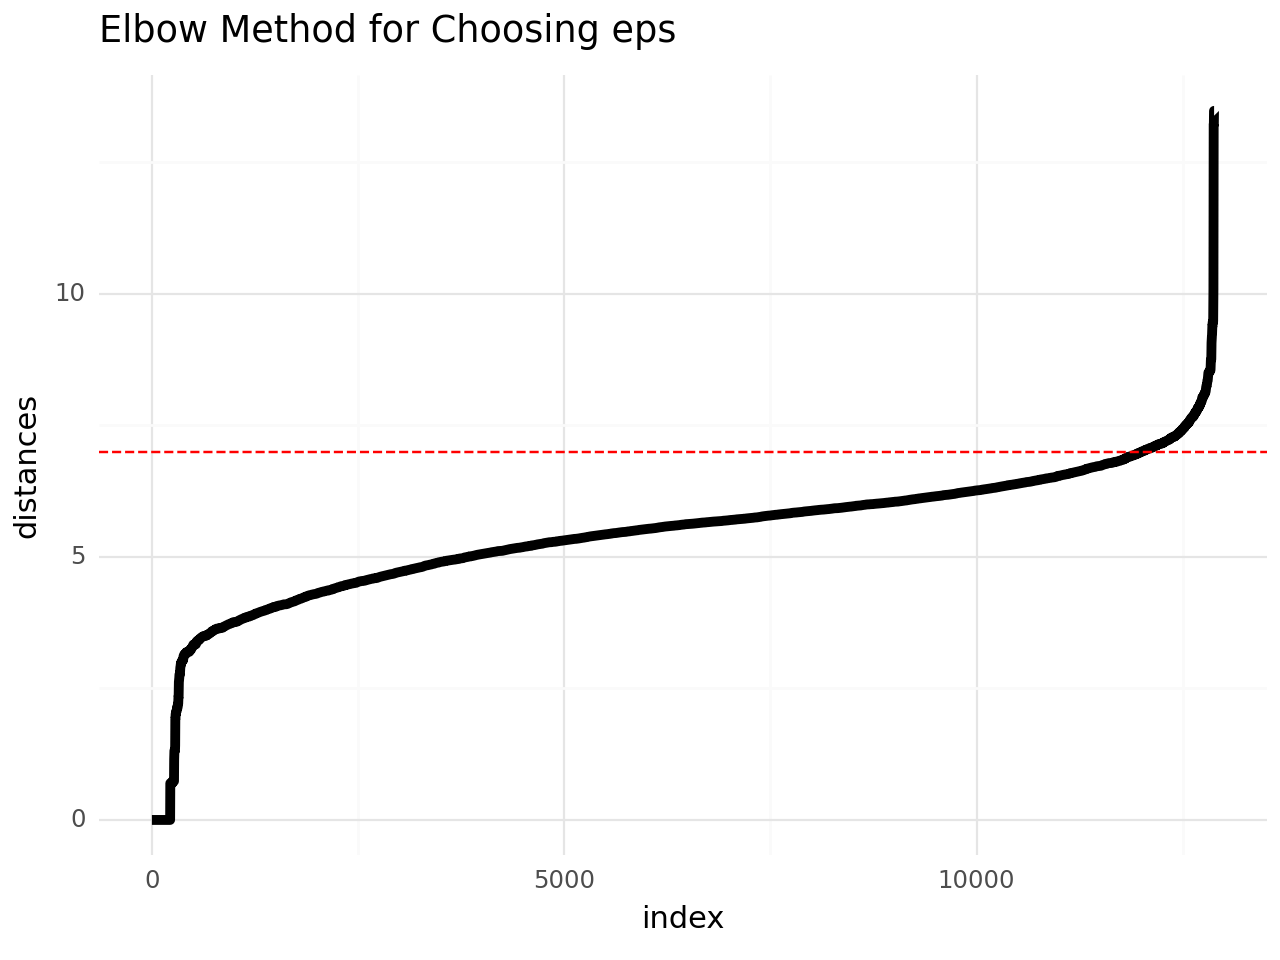

<Figure Size: (640 x 480)>

In [ ]:
#Using the elbow method to choose eps and min_samples for DBSCAN

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from plotnine import *
import pandas as pd

mins = 25
nn = NearestNeighbors(n_neighbors = mins + 1)

# create pipeline
pipe_elbow = Pipeline([
    ("nn", nn)
])

# fit nn model
pipe_elbow.fit(embeddings)

# get neighbors
distances, neighbors = pipe_elbow.named_steps["nn"].kneighbors(embeddings)

# sort the distances
distances = np.sort(distances[:, mins], axis = 0)

#plot the distances
distances_df = pd.DataFrame({"distances": distances,
                             "index": list(range(0,len(distances)))})
plt = (ggplot(distances_df, aes(x = "index", y = "distances")) +
 geom_line(size = 2) + theme_minimal() +
 labs(title = "Elbow Method for Choosing eps") +
       geom_hline(yintercept = 7, color = "red", linetype = "dashed") # my estimate for inflection point... looks like 7??
       )

plt

In [ ]:
# Apply clustering to embeddings
embeddings = np.vstack(embeddings)
clustering = DBSCAN(eps=7, min_samples=38).fit(embeddings)
#Min_samples ....
#5 is too low
#50 is too high

cluster_labels = clustering.labels_
# Analyze clusters for topic discovery...???
# will examine texts in each cluster to identify common themes or topics... not possible without labels??

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, perplexity=20, random_state=42)
tsne_embeddings = tsne_model.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis')
plt.title('t-SNE visualization of BERT embeddings with DBSCAN cluster labels')
plt.colorbar(scatter)
plt.show()

### ATTEMPT 3 -- USEME

- This is attempt 3 in my project. digging deeper into BERT and tokenizing sentences, adding labels so I can cluster better.

- Utilizing a random forest classifier on the embeddings to build predictivity
- Evaluating the model with metrics
- predicting the company that shraed it and predicting the theme of the report

In [ ]:
#This takes +30 minutes to run!!

import os
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode

folder_path = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Shareholder Reports TXT'
embeddings = [] # List to store embeddings generated from the BERT model
company_labels = []  # List to store company labels
theme_labels = []    # List to store theme labels

# Function to determine the theme label
def determine_theme(text):
    # Determining the theme of the report based on the certain keywords

    if "bank" in text.lower():
        return "Financial"
    elif "car" or "tesla" or "vehicle" or "vehicles" in text.lower():
        return "Automobile"
    elif "gpu" or "network" or "ai" in text.lower():
        return "Technology"
    elif "food" in text.lower():
        return "Food"
    elif "medical" in text.lower():
        return "Medical"
    elif "customer" in text.lower():
        return "Customer Relations"
    return "Other"

# Read and process each file
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        company_label = filename.split('.')[0]  # Extract company label from filename
        print(company_label)
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            theme_label = determine_theme(text)  # Determine the theme label
            print(theme_label)
            sentences = text.split('\n')  # Assuming each sentence is on a new line
            for sentence in sentences:
                inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512, padding=True)
                with torch.no_grad():
                    outputs = model(**inputs)
                sentence_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
                embeddings.append(sentence_embedding)
                company_labels.append(company_label)
                theme_labels.append(theme_label)

#This is setting up the data that goes into the model. Starts with determining the theme,
#and the embeddings that are the most important aspects of the model in the next part

In [ ]:
#Extracting the text from my test file! Model was not trained on this file...
import os
import pdfplumber
'''
# Extract text and save to a .txt file
with pdfplumber.open("/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/test_data.pdf") as pdf, open('/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Test_File.txt', 'w') as text_file:
  for page in pdf.pages:
      text = page.extract_text()
      if text:
          text_file.write(text)
          text_file.write('\n')  # Add a newline between pages


In [ ]:
#Visual to see the labels for company and theme
import pandas as pd
df = pd.DataFrame({"Company Labels" : company_labels,
                   "Theme Labels": theme_labels})
df['Company Labels'].value_counts()

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

# 'embeddings' is list of BERT embeddings
# 'company_labels' and 'theme_labels' are lists of labels for each embedding
X_train, X_test, y_train_company, y_test_company = train_test_split(embeddings, company_labels, test_size=0.1, random_state=42)
X_train, X_test, y_train_theme, y_test_theme = train_test_split(embeddings, theme_labels, test_size=0.1, random_state=42)

# Train model for company identification
company_classifier = RandomForestClassifier() # Using a random forest classifier for predictions
company_classifier.fit(X_train, y_train_company) # Fitting model on the training set

# Train model for thematic classification
theme_classifier = RandomForestClassifier() # Using a random forest classifier for predictions
theme_classifier.fit(X_train, y_train_theme) # Fitting model on the training set

# Evaluate the models
company_pred = company_classifier.predict(X_test) #Grabbing the accuracy scores
theme_pred = theme_classifier.predict(X_test) #Grabbing the accuracy scores
print("Company Prediction Accuracy:", accuracy_score(y_test_company, company_pred))
print("Theme Prediction Accuracy:", accuracy_score(y_test_theme, theme_pred))
print()

# Predicting on a new text file function
def predict_new_text(file_path, tokenizer, model, company_classifier, theme_classifier):
    with open(file_path, 'r') as file: # Reading in the file to analyze it given the trained model
        text = file.read()
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        predicted_company = company_classifier.predict([embedding])
        predicted_theme = theme_classifier.predict([embedding])
        return predicted_company[0], predicted_theme[0]

#Predicting with new text, first try
new_text_path = "/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Test_File.txt"
predicted_company, predicted_theme = predict_new_text(new_text_path, tokenizer, model, company_classifier, theme_classifier)
print("Predicted Company 1:", predicted_company, "; Actual Company: General Motors")
print("Predicted Theme 1:", predicted_theme, "; Actual Theme: Automobile")

#Predicting with text, second try
new_text_path = "/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Copy of Q1-2023-Amazon-Earnings-Release.txt"
predicted_company, predicted_theme = predict_new_text(new_text_path, tokenizer, model, company_classifier, theme_classifier)
print("Predicted Company 2:", predicted_company, "; Actual Company: Amazon")
print("Predicted Theme 2:", predicted_theme, "; Actual Theme: Technology")

#The file I used to test it is General Motors, Q3 Shareholder press report. NOT trained on
#The second file I used was seen by the model. Q1 Amazon shareholder press report

''' Output:
Company Prediction Accuracy: 0.15748440748440748
Theme Prediction Accuracy: 0.8305613305613305

Predicted Company 1: SNAP-Q2 ; Actual Company: General Motors
Predicted Theme 1: Financial ; Actual Theme: Automobile
Predicted Company 2: SOFI-Q3 ; Actual Company: Amazon
Predicted Theme 2: Financial ; Actual Theme: Technology

'''

Company Prediction Accuracy: 0.15748440748440748
Theme Prediction Accuracy: 0.8305613305613305

Predicted Company 1: SNAP-Q2 ; Actual Company: General Motors
Predicted Theme 1: Financial ; Actual Theme: Automobile
Predicted Company 2: SOFI-Q3 ; Actual Company: Amazon
Predicted Theme 2: Financial ; Actual Theme: Technology


' Output:\n'

#MODEL - STOCKS

- A model that uses LSTM. This model is widely used in stock prediction.

- In this case, I want to see if stocks change based on the release month/date of the shareholder report for the company

- Anohter model that uses XGBoost model to analyze the data using a random forest boosting logic

-

### ATTEMPT 1

- This is trying to use LSTM on the stock data for 2023. there are 100 companies
- Attempting the plot it, didnt work or make sense

In [ ]:
#This takes +20 min to run
#This doesnt work


import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        label = data[i + sequence_length]
        X.append(sequence)
        y.append(label)
    return np.array(X), np.array(y)

folder_path = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Yahoo Finance Stock Data'
sequence_length = 100
scaler = MinMaxScaler(feature_range=(0, 1))

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        # Load data
        dataframe = pd.read_csv(file_path)
        # 'Close' is the closing price of the stock
        prices = dataframe['Close'].values.reshape(-1, 1)
        # Normalize data
        scaled_prices = scaler.fit_transform(prices)
        # Create sequences
        X, y = create_sequences(scaled_prices, sequence_length)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9,
                                                            random_state = 42,
                                                            shuffle = False)

        # Build LSTM model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
            LSTM(50),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train
        model.fit(X_train, y_train, epochs=10, batch_size=32)

#Predict !!
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


In [ ]:
#Doesnt work
#Trying to make a plot for stock prices over time period

plt.plot(X_test, color = 'black', label = ' Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### ATTEMPT 2
- Trying LSTM again, in a different way. Using a different ways to go about the company data in the model to better classify the stock data
- looking at if the stock price decreased or increased?

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


folder_path = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Yahoo Finance Stock Data'
combined_data = pd.DataFrame()

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        company_ticker = filename.split('_')[0]
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['Ticker'] = company_ticker
        combined_data = combined_data.append(df)

# Reset index after combining all dataframes
combined_data.reset_index(drop=True, inplace=True)

# Feature Engineering!!
combined_data['Price_Change'] = combined_data['Close'].pct_change()  # Percentage change in closing price
combined_data['Label'] = combined_data['Price_Change'].apply(lambda x: 1 if x > 0 else 0)  # 1 if price increased, 0 otherwise

# Normalize features
scaler = StandardScaler()
combined_data['Scaled_Close'] = scaler.fit_transform(combined_data[['Close']])

def create_sequences(df, sequence_length):
    X, y = [], []
    data = df['Scaled_Close'].values
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(df['Label'].iloc[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60  # The number of days to look back
X, y = create_sequences(combined_data, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model using adam and binary_crossentropy, using accuracy score as the metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
report = classification_report(y_test, y_pred_class, target_names=['Decrease', 'Increase'])
print(report)


In [ ]:
# XGBoost model?
# From class, using logloss... meh

xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

### ATTEMPT 3 -- USEME
- Attempting to build a model that can show me if the stock prices changed around the shareholder report being released
- utilizing the LStM model on a new company that I want to predict in the field as well as using their historical data and predicting their Q4 2023 stock price change for their shareholder report

In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Function to create sequences for LSTM
def create_sequences(df, n_past):
    X, y = [], []
    for i in range(n_past, len(df)):
        X.append(df[i - n_past:i, :-1])  # All columns except the last one
        y.append(df[i, -1])  # The last column
    return np.array(X), np.array(y)

# Preprocess the entire dataset
def preprocess_data(stock_data, n_past):
    all_X, all_y = [], []
    for ticker in stock_data['Ticker'].unique():
        company_data = stock_data[stock_data['Ticker'] == ticker].drop(['Date', 'Ticker'], axis=1)
        X, y = create_sequences(company_data.values, n_past)
        all_X.extend(X)
        all_y.extend(y)
    return np.array(all_X), np.array(all_y)

# Parameters
n_past = 30

folder_path = '/content/drive/MyDrive/Colab Notebooks/MGSC 310/Portfolio Project/Stock Data'

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Loop through each file and concatenate directly
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        all_data = pd.concat([all_data, df], ignore_index=True)

# Preprocess and split the data
X, y = preprocess_data(all_data, n_past)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# LSTM Model
model = Sequential([
    LSTM(50, input_shape=(n_past, X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

# Prediction Function
def predict_price(ticker, model, stock_data, date_to_predict, n_past):
    data_to_predict = stock_data[(stock_data['Ticker'] == ticker) & (stock_data['Date'] < date_to_predict)].drop(['Date', 'Ticker'], axis=1)
    X_predict = create_sequences(data_to_predict.values, n_past)[0][-1:]  # Get the last sequence
    return model.predict(X_predict)[0][0]

In [23]:
# Example Prediction
future_date = '2023-11-30'
ticker_to_predict = 'AAPL'
predicted_price = predict_price(ticker_to_predict, model, all_data, future_date, n_past)
print(f"Predicted Price for {ticker_to_predict} on {future_date}: {predicted_price}")

1/1 [==============================] - 1s 509ms/step
Predicted Price for AAPL on 2023-11-30: 105.63434600830078
